In [ ]:
# GC Content Analysis for Real FASTA Files

In [3]:
# ----------------------------------------
# FASTA PARSING + GC% UTILITIES (REUSABLE)
# ----------------------------------------

# 'def' defines a function (reusable block of code) named 'read_fasta_single'.
# 'path' is the single parameter (input) and is expected to be a string path to a FASTA file.
def read_fasta_single(path):
    header = None                # variable 'header' starts as None (no value yet)
    parts = []                   # 'parts' is a list to collect sequence lines
    # 'with open(path, "r") as fh:' opens the file for reading ('r'); 'fh' = file handle var
    with open(path, "r", encoding="utf-8") as fh:   # 'encoding' ensures proper text decoding
        # 'for line in fh:' loops over each line of the file
        for line in fh:
            line = line.strip()  # '.strip()' removes whitespace/newline at both ends
            if not line:         # 'if not line:' means "if line is empty", skip
                continue
            if line.startswith(">"):         # FASTA header lines begin with '>'
                header = line[1:].strip()    # take everything after '>' via slice [1:], then strip spaces
            else:
                # sequence line: remove spaces and uppercase it; append to our list
                parts.append(line.replace(" ", "").upper())
    seq = "".join(parts)    # ''.join(list_of_strings) concatenates list elements into one big string
    return header, seq      # 'return' sends (header, sequence_string) back to the caller

# 'def' defines a function to compute the GC fraction (0..1) of a DNA string 'dna'.
def gc_fraction(dna):
    dna = dna.upper()   # ensure consistent uppercase
    # 'sum(1 for b in dna if b in ("G","C"))' adds 1 for each base 'b' that is G or C
    gc = sum(1 for b in dna if b in ("G", "C"))
    # count only valid A/C/G/T letters; ignore N or other symbols
    acgt = sum(1 for b in dna if b in ("A", "C", "G", "T"))
    # avoid divide-by-zero: if acgt==0 return 0.0 else return gc/acgt
    return (gc / acgt) if acgt > 0 else 0.0

# sliding window generator over 'dna'; default window=500, step=250 (good for larger sequences)
def sliding_windows(dna, window=500, step=250):
    n = len(dna)   # total length (number of bases)
    i = 0          # start index at 0
    # 'while i < n:' loop until we reach sequence end
    while i < n:
        j = i + window                # end index (exclusive)
        if j > n:                     # clamp to end if past length
            j = n
        # 'yield' returns a tuple (i, j, subseq) but keeps generator state for next iteration
        yield (i, j, dna[i:j])
        if j == n:     # if we've reached the very end, stop looping
            break
        i += step      # advance by 'step' bases

# compute windowed GC profile as list of dicts (each dict = one row)
def gc_profile(dna, window=500, step=250):
    rows = []  # empty list to collect dictionaries
    # 'for start, end, sub in sliding_windows(...)' unpacks the 3-tuple yielded by the generator
    for start, end, sub in sliding_windows(dna, window=window, step=step):
        gc_pct = gc_fraction(sub) * 100.0              # convert fraction (0..1) to percent (0..100)
        rows.append({                                   # append a dict (key:value pairs)
            "start": start,                             # window start (0-based)
            "end": end,                                 # window end (exclusive)
            "length": end - start,                      # window length (may be shorter at end)
            "gc_percent": gc_pct                        # numeric GC% (float)
        })
    return rows


In [4]:
# -------------------------------------------------------
# ONE-CALL ANALYSIS: READ FASTA -> GC% -> CSV/FIGURES OUT
# -------------------------------------------------------

# Imports for this cell: filesystem + CSV + plotting
from pathlib import Path          # 'Path' gives nicer path handling than raw strings
import csv                        # 'csv' standard lib for writing comma-separated files
import matplotlib.pyplot as plt   # plotting library (no seaborn; one chart per figure)

def analyze_fasta(fasta_path, out_dir, window=500, step=250, title_hint=None):
    """
    Run GC analysis on 'fasta_path', save outputs into 'out_dir'.
    - 'fasta_path' (str or Path): location of the FASTA file to analyze
    - 'out_dir'   (str or Path): folder to place CSVs and PNGs
    - 'window'    (int): window size for sliding GC (bases)
    - 'step'      (int): step size between windows (bases)
    - 'title_hint'(str or None): optional short label to include in plot titles
    Returns: a small dict with 'overall_gc' and 'n_windows'.
    """
    # Ensure output dir exists
    out_dir = Path(out_dir)                 # make sure we have a Path object
    out_dir.mkdir(parents=True, exist_ok=True)  # create folder (and parents) if missing

    # ---- Read FASTA ----
    hdr, dna = read_fasta_single(str(fasta_path))   # use our utility; cast Path->str for safety
    # Basic sanity printouts
    print("FASTA header:", hdr)
    print("Length (bp) :", len(dna))

    # ---- Compute metrics ----
    overall_gc = gc_fraction(dna) * 100.0           # convert to percent
    rows = gc_profile(dna, window=window, step=step)

    print(f"Overall GC% : {overall_gc:.2f}%")
    print(f"Windows     : {len(rows)} (window={window}, step={step})")

    # ---- Save CSV: window table ----
    csv_windows = out_dir / "gc_windows.csv"        # Path to results CSV
    # open the CSV file for writing text ('w'); newline='' avoids extra blank lines on Windows
    with open(csv_windows, "w", newline="", encoding="utf-8") as fh:
        writer = csv.DictWriter(fh, fieldnames=["start", "end", "length", "gc_percent"])
        writer.writeheader()                        # first row: column names
        for r in rows:                              # write each dict row
            writer.writerow(r)

    # ---- Save CSV: extremes (top/bottom K windows) ----
    K = 10
    rows_sorted = sorted(rows, key=lambda r: r["gc_percent"])  # ascending by GC%
    lowest = rows_sorted[:K]
    highest = rows_sorted[-K:][::-1]                           # top K, then reverse to desc
    csv_extremes = out_dir / "gc_extremes.csv"
    with open(csv_extremes, "w", newline="", encoding="utf-8") as fh:
        writer = csv.DictWriter(fh, fieldnames=["which","rank","start","end","length","gc_percent"])
        writer.writeheader()
        for i, r in enumerate(lowest, start=1):                 # enumerate gives (1, row1), (2, row2)...
            writer.writerow({"which":"lowest", "rank":i, **r})  # **r unpacks keys from r into the dict
        for i, r in enumerate(highest, start=1):
            writer.writerow({"which":"highest", "rank":i, **r})

    # ---- Plot 1: GC% vs position ----
    xs = [ (r["start"] + r["end"]) / 2 for r in rows ]   # window midpoint
    ys = [ r["gc_percent"] for r in rows ]               # GC% values

    plt.figure()                                         # start new figure (one chart)
    plt.plot(xs, ys)                                     # default line plot
    plt.xlabel("Genomic position (bp)")                  # x-axis label
    plt.ylabel("GC% (windowed)")                         # y-axis label
    # build a title string (optionally include 'title_hint' and window/step)
    t = "GC% profile"
    if title_hint:
        t += f" — {title_hint}"
    t += f" (window={window}, step={step})"
    plt.title(t)
    fig1 = out_dir / "gc_profile.png"                    # output path for figure
    plt.savefig(fig1.as_posix(), dpi=200, bbox_inches="tight")  # save PNG; dpi=200 for clarity

    # ---- Plot 2: Overall GC% bar (single thin bar) ----
    plt.figure()                                         # new figure
    plt.bar([0], [overall_gc], width=0.3)                # one bar at x=0; width=0.3 thinner than default
    plt.xticks([0], ["Overall GC%"])                     # label the lone bar
    plt.ylabel("GC%")                                    # y-axis label
    plt.title("Overall GC%")
    plt.xlim(-1, 1)                                      # widen x-limits so the bar appears thin
    fig2 = out_dir / "gc_overall.png"
    plt.savefig(fig2.as_posix(), dpi=200, bbox_inches="tight")

    # ---- Return a small summary dict to the caller ----
    return {"overall_gc": overall_gc, "n_windows": len(rows), "csv": str(csv_windows), "fig_profile": str(fig1)}


FASTA header: NC_012920.1 Homo sapiens mitochondrion, complete genome
Length (bp) : 16569
Overall GC% : 44.36%
Windows     : 110 (window=300, step=150)
FASTA header: NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome
Length (bp) : 4641652
Overall GC% : 50.79%
Windows     : 1856 (window=5000, step=2500)

--- Summaries ---
Human mtDNA: {'overall_gc': 44.362626750362146, 'n_windows': 110, 'csv': '/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/results/mtDNA/gc_windows.csv', 'fig_profile': '/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/results/mtDNA/gc_profile.png'}
E. coli    : {'overall_gc': 50.79070985933456, 'n_windows': 1856, 'csv': '/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/results/ecoli/gc_windows.csv', 'fig_profile': '/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/results/ecoli/gc_profile.png'}


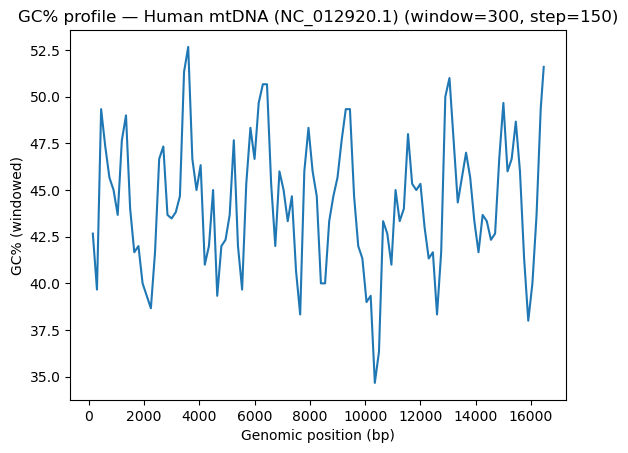

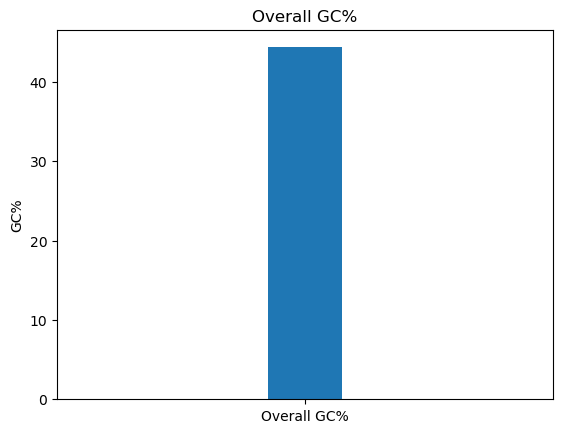

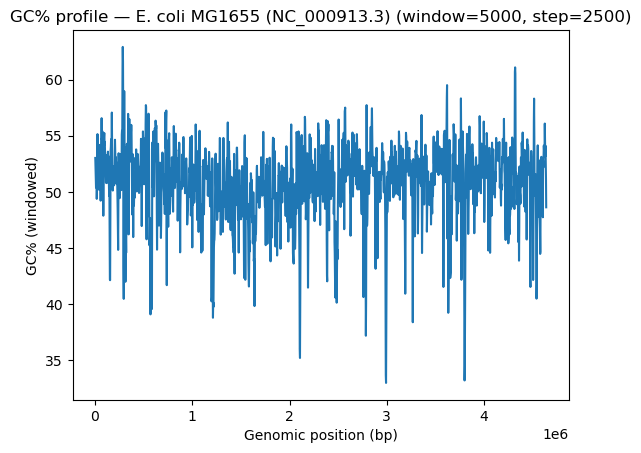

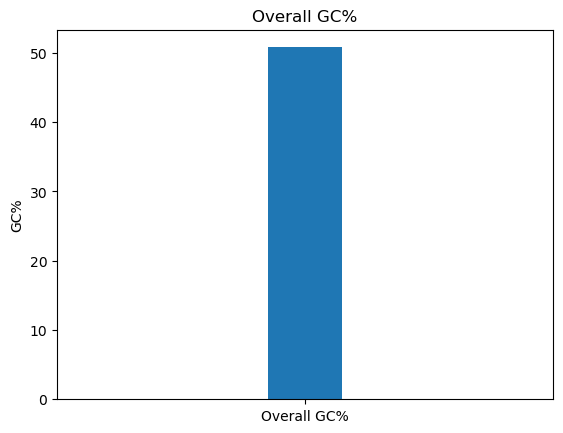

In [5]:
# ---------------------------------------------
# RUN ANALYSIS: human mtDNA and E. coli MG1655
# ---------------------------------------------

from pathlib import Path   # ensure Path is available in this cell

BASE = Path().resolve()    # current notebook directory (absolute)
DATA = BASE / "data"       # 'data' folder where FASTAs were saved

# Build FASTA paths (must match the names you used in your download cell)
mt_fasta   = DATA / "human_mtDNA_NC_012920.1.fasta"
ec_fasta   = DATA / "Ecoli_MG1655_NC_000913.3.fna"

# Choose window/step per genome size:
# - Human mtDNA ~16.6 kb: smaller windows work (e.g., 300 / 150)
# - E. coli genome ~4.6 Mb (MG1655): larger windows for smoothness (e.g., 5000 / 2500)
mt_params  = {"window": 300,  "step": 150}
ec_params  = {"window": 5000, "step": 2500}

# OUT dirs for results
mt_outdir  = BASE / "results" / "mtDNA"
ec_outdir  = BASE / "results" / "ecoli"

# Run analyses (title_hint appears in plot titles)
mt_summary = analyze_fasta(mt_fasta, mt_outdir, **mt_params, title_hint="Human mtDNA (NC_012920.1)")
ec_summary = analyze_fasta(ec_fasta, ec_outdir, **ec_params, title_hint="E. coli MG1655 (NC_000913.3)")

# Print small summaries so you can see outcomes at a glance
print("\n--- Summaries ---")
print("Human mtDNA:", mt_summary)
print("E. coli    :", ec_summary)


In [1]:
# ------------------------------------------------------
# APPEND A "DATA SOURCES" SECTION TO THE END OF README
# ------------------------------------------------------

from pathlib import Path   # path handling
import datetime            # to stamp today's date

readme_path = Path("README.md")   # the README file in repo root

# Build a markdown section. We include the two NCBI accessions and viewer links.
# Triple quotes = multi-line string; 'f"""..."""' allows inline {expressions}.
sources_md = f"""

---

## Data Sources
- **Human mitochondrion (rCRS)** — NCBI RefSeq **NC_012920.1**  
  FASTA viewer: https://www.ncbi.nlm.nih.gov/sviewer/viewer.fcgi?id=NC_012920.1&db=nuccore&report=fasta
- **Escherichia coli K-12 substr. MG1655** — NCBI RefSeq **NC_000913.3**  
  FASTA viewer: https://www.ncbi.nlm.nih.gov/sviewer/viewer.fcgi?id=NC_000913.3&db=nuccore&report=fasta

*This section was appended on {datetime.date.today().isoformat()} to cite sequence sources used in analyses.*
"""

# Read existing README (if present), then append the sources block and write back.
if readme_path.exists():                              # True if file already exists
    current = readme_path.read_text(encoding="utf-8") # read entire file as text
else:
    current = "# Project README\n"                    # minimal fallback

readme_path.write_text(current + sources_md, encoding="utf-8")  # write combined text
print("README updated with Data Sources.")


README updated with Data Sources.
